## 00:00:00 - Fast.AI student article recap

* [Structured Deep Learning](https://towardsdatascience.com/structured-deep-learning-b8ca4138b848?gi=47b0bbe61a30)
* [Fun with small image data-sets (Part 2)](https://towardsdatascience.com/fun-with-small-image-data-sets-part-2-54d683ca8c96)
  * Vendors claimed that huge datasets and massive compute is required to do deep learning, but this post proves that's not the case.
* [How do we train neural networks ?](https://towardsdatascience.com/how-do-we-train-neural-networks-edd985562b73)


## 00:07:48 - 2nd half of course overview

* First half:
  * Learn about applications.
  * Learn best practises.
* Second half:
  * Learn what the Fast.ai libraries are doing under the hood.

## 00:09:01 - Collaborative filtering model from scratch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.fastai.learner import *
from fastai.fastai.column_data import *

In [3]:
PATH = 'data/ml-latest-small/'

In [3]:
!mkdir {PATH}

mkdir: data/ml-latest-small/: File exists


* Download Movielens dataset:

In [5]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip --directory-prefix={PATH}

--2018-04-23 16:34:39--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org... 128.101.34.235
Connecting to files.grouplens.org|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: ‘data/ml-latest-small/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 896.75K   229KB/s    in 3.9s    

2018-04-23 16:34:44 (229 KB/s) - ‘data/ml-latest-small/ml-latest-small.zip’ saved [918269/918269]



In [6]:
!cd {PATH} && unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/movies.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/tags.csv  


In [4]:
!ls -l {PATH}

total 7936
-rw-r--r--  1 lex  staff     8364 18 Oct  2016 README.txt
-rw-r--r--  1 lex  staff   183372 18 Oct  2016 links.csv
drwxr-xr-x  7 lex  staff      238 18 Oct  2016 ml-latest-small
-rw-r--r--  1 lex  staff   918269 18 Oct  2016 ml-latest-small.zip
drwxr-xr-x  2 lex  staff       68 23 Apr 17:31 models
-rw-r--r--  1 lex  staff   458390 18 Oct  2016 movies.csv
-rw-r--r--  1 lex  staff  2438266 18 Oct  2016 ratings.csv
-rw-r--r--  1 lex  staff    41902 18 Oct  2016 tags.csv
drwxr-xr-x  2 lex  staff       68 23 Apr 17:31 tmp


* Each dataset row contarins:
  * Rating
  * User id
  * Movie id
  * Timestamp (not used in model)

In [4]:
ratings = pd.read_csv(f'{PATH}ratings.csv')

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


* Load in movie names for display purposes:

In [6]:
movies = pd.read_csv(f'{PATH}movies.csv')

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### 00:10:50 - Solve MovieLens in Excel

* Create crosstab of most popular movies and users with most ratings for Excel:

In [8]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


* Excel can perform gradient descent with the Solver Add On (I couldn't get it to work in Google Sheets):

    1. Initialise 5 random numbers for each movie, and each user.
    2. Solver then performs gradient descent on those numbers, attempting to minimise the loss (RMSE).

* Intuition for the "latent factors" (random number) is basically each number refers to some feature (how much user like action films) which are learned.
* Called collaborative filtering using "probabilistic matrix factorization".

### 00:21:32 - Audience questions

* Q1: Should we cap the factorization outputs to between 0 and 5?
* A1: Yes. We'll do that later.

* Q2: How do you figure out how many latent factors you need?
* A2: Since you're building an embedding matrix, the same rules apply: cardinality of class / 2 (try a few things and see what works).

* Q3: What does it mean when the factor is negative?
* A3: In the movie case: the movie is not dialog driven at all (as an example), in the user case: user actively dislikes some genre.

* Q4: How can we trust these numbers?
* A4: We are using gradient descent to find the best numbers, so there could be other numbers but these provide the lowest loss.

* Q5: If we have a new user and new movie, do we have to retrain the model?
* A5: You could have a new user and new movie model to support stuff temporarily, but over time you'd need to retrain your model.

### 00:26:02 - Solving with Fast.AI

* Create validation set:

In [9]:
val_idxs = get_cv_idxs(len(ratings))

* Set weight decay (aka l2 regularisation):

In [10]:
wd = 2e-4

* How big is the embedding matrix?

In [11]:
n_factors = 50

In [12]:
cf = CollabFilterDataset.from_csv(PATH, 'ratings.csv', 'userId', 'movieId', 'rating')

In [13]:
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [14]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.808714   0.807408  
    1      0.770412   0.777587                                 
    2      0.624947   0.76404                                  



[0.76404047]

* What collaborative filtering is doing:
  * For this user and movie, what other users are similar to them, based on their preference?

* Take sqrt of RMSE:

In [15]:
math.sqrt(0.764737)

0.8744924242096097

### 00:31:30 - Analyse predictions

In [17]:
preds = learn.predict()

In [18]:
y = learn.data.val_y

* Plot a summary of the data using the [Seaborn](https://seaborn.pydata.org) library:

//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


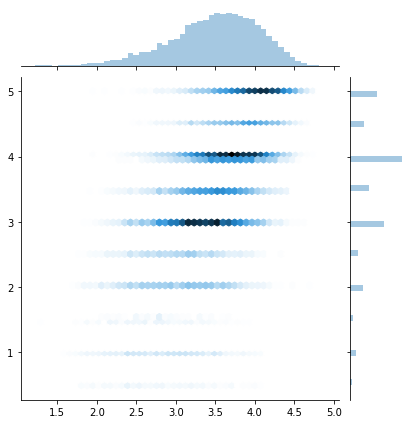

In [19]:
sns.jointplot(preds, y, kind='hex', stat_func=None);

### 00:32:16 - Audience questions

* Q1: Why is n_factors set to 50?
* A1: Jeremy tried a few and it seemed to work the best.

## 00:33:55 - Dot product in PyTorch

* Can create a Tensor using the Fast.AI `T` function:

In [14]:
T

<function fastai.fastai.core.T(a)>

In [15]:
a = T([[1., 2], [3, 4]])
b = T([[2., 2], [10, 10]])
a, b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

  * Equivalent to `torch.FloatTensor`:

In [16]:
torch.FloatTensor(np.array([[1., 2], [3., 4]]))


 1  2
 3  4
[torch.FloatTensor of size 2x2]

* Can multiple element-wise using the Python multplication operators:

In [17]:
a * b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

* The columns can be summed, as follows:

In [18]:
(a * b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

### 00:37:17  - PyTorch module

* PyTorch module can be used as a layer in a neural net.
  * Can call the object with some tensors, and it will perform a calculation:

In [19]:
class DotProduct(nn.Module):
    def forward(self, u, m):
        return (u * m).sum(1)

In [20]:
model = DotProduct()

In [21]:
model(a, b)


  6
 70
[torch.FloatTensor of size 2]

  * Can take the derivative of a Module and stack/compose into a larger model.

### 00:38:54 - Audience questions

* Q1: If you have a lot of data can you use Fast.ai library?
* A1: Yes, because it uses SGD which iterates through a dataset one batch at a time.
  * Pandas dataframes do need to live in memory, but you could save it as a bcolz array or a [Dask](http://dask.pydata.org/) dataframe.

### 00:40:17 - `forward` method

* Calculations in a `Module` must be performed in the `forward` method.

### 00:41:34 - Collaborative filtering in PyTorch

* User id and movie id may not be contiguous, so we have to convert them into contiguous values, as follows:

In [16]:
# Get unique users
u_uniq = ratings.userId.unique()

In [17]:
# Great id to position dict
user2idx = {o:i for i, o in enumerate(u_uniq)}

In [18]:
# Convert user id to idx
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

In [19]:
# Get unique movies
m_uniq = ratings.movieId.unique()

In [20]:
# Get movie id to position dict
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [21]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())

* Module constructor can take any arguments, you just need to ensure the parent constructor is also run (`super().__init__`)
  * We also ensure that the random initialisation are around the value we need:

In [22]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        
        # Create 2 embedding matrixes, one vector of n_factors for each user.
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        
        # Generate a uniform random matrix between 0 and 0.05
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)

    def forward(self, cats, cont):
        # Get user and movie minibatch
        users, movies = cats[:,0], cats[:,1]
        
        # Look up minibatch in self.u and self.m
        u, m = self.u(users), self.m(movies)
        
        # Perform a dot product
        return (u*m).sum(1)

* PyTorch convention for inplace methods it to include a `_` after it: `.uniform` vs `.uniform_`.

* Create columnar data from a data frame as before:

In [23]:
x = ratings.drop(['rating', 'timestamp'], axis=1)
y = ratings['rating']

In [24]:
data = ColumnarModelData.from_data_frame(PATH, val_idxs, x, y, ['userId', 'movieId'], 64)

* Create an optimizer (the thing that will update the weights):
  * In PyTorch weights are refered to as `parameters`:

In [25]:
wd = 1e-5
model = EmbeddingDot(n_users, n_movies)
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

* Training loop is the thing that iterates through each minibatch and updates the weights.
* Fast.ai has it's own training loop:

In [26]:
fit

<function fastai.fastai.model.fit(model, data, epochs, opt, crit, metrics=None, callbacks=None, stepper=<class 'fastai.fastai.model.Stepper'>, **kwargs)>

* Fast.ai is designed to allow you to pick whatever layer of abstraction you need.

In [27]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                 
    0      1.647313   1.628666  
    1      1.149324   1.309592                                 
    2      0.962456   1.227627                                  



[1.2276269]

* Can see that we still aren't getting the sort of loss we were getting before. Few more things required to get there.
* Can change the learning rate with `set_lrs` function:

In [28]:
set_lrs(opt, 0.01)

In [29]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.714701   1.149281  
    1      0.717828   1.136802                                  
    2      0.688072   1.131916                                  



[1.1319162]

### 00:58:39 - Walk through of model.py

* Where `fit` lives.

## 01:00:32 - Adding bias to embedding model

* Some users may be super enthusiatic and tend to rate movies high, similarly, some movies may just be popular.
* Want to introduce a constant to deal with this aka **bias**.
* Excel example:
  * Add extra row bias row to movie vectors and a column to the user vectors, which is just added to the calculation: `MMULT($B28:$F28,H$20:H$24)+H$19+$A28` 
* Get min and max rating, to limit output of rating predictions:

In [30]:
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()
min_rating, max_rating

(0.5, 5.0)

In [31]:
def get_emb(num_inputs, num_factors):
    e = nn.Embedding(num_inputs, num_factors)
    e.weight.data.uniform_(0, 0.05)
    return e


class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.user_emb = get_emb(n_users, n_factors)
        self.movies_emb = get_emb(n_movies, n_factors)
        
        # Add a bias and movies embedding with 1 factor.
        self.user_bias_emb = get_emb(n_users, 1)
        self.movie_bias_emb = get_emb(n_movies, 1)
        
    def forward(self, cats, conts):
        users, movies = cats[:,0], cats[:,1]
        um = (self.user_emb(users) * self.movies_emb(movies)).sum(1)
        res = (
            um +
            self.user_bias_emb(users).squeeze() +
            self.movie_bias_emb(movies).squeeze()
        )
        
        # Squish all rating to be between 1 and 5.
        res = F.sigmoid(res) * (max_rating - min_rating) + min_rating
        return res

  * ``squeeze`` removes all dimensions of size 1 to be removed.

In [32]:
T([[[1,2, 3], [4,5,6]]]).shape

torch.Size([1, 2, 3])

In [33]:
T([[[1,2,3], [4,5,6]]]).squeeze().shape

torch.Size([2, 3])

* In PyTorch all operators you can do to Tensors are in `torch.nn.functional` which is usually imported as `F`: 

In [34]:
import torch.nn.functional as F

* Fitting the model:

In [35]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items)
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [36]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.842212   0.83497   
    1      0.781383   0.80926                                   
    2      0.790545   0.796428                                  



[0.79642844]

In [37]:
set_lrs(opt, 1e-2)

In [38]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.734044   0.789175  
    1      0.692277   0.787734                                  
    2      0.699569   0.786593                                  



[0.7865928]

* That is how collaborative filtering is generally done.
* What's done is similar to a matrix factorization, however, it had to be modified slightly to allow for empty values.
  * Only calculates loss for user + movie combinations that actually exist.
  * "Probabilistic Matrix Factorization"

### Audience questions - 01:16:52

* Q1: Could we improve the model using the date?
* A1: Possibly - worth a try. Could take the `EmbeddingDotBias` class out of Fast.ai and rework it.

## 01:17:20 - Neural Network version of CF

1. Take the user embedding and the movie embedding, then concat them to get a shape of `(1, 10)`
2. Feed them into a weight matrix that's `(10, <column num)>`
3. Push it through a ReLU.
4. Feed those outputs into a `(<column num)>, 1)` linear layer.

In [39]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.user_emb = get_emb(n_users, n_factors)
        self.movies_emb = get_emb(n_movies, n_factors)
        
        # Note: linear layers include bias.
        self.lin1 = nn.Linear(n_factors * 2, 10)
        self.lin2 = nn.Linear(10, 1)
        
    def forward(self, cats, conts):
        users, movies = cats[:,0], cats[:,1]
        x = F.dropout(
            torch.cat([
                self.user_emb(users),
                self.movies_emb(movies)], dim=1), 0.75)
        x = F.dropout(F.relu(self.lin1(x)), 0.75)
        return F.sigmoid(
            self.lin2(x)) * (max_rating - min_rating + 1) + min_rating - 0.5

In [40]:
wd=5e-4
model = EmbeddingNet(n_users, n_movies)
opt = optim.SGD(model.parameters(), 1e-2, weight_decay=wd, momentum=0.9)

In [44]:
# Note that we're passing the loss function to `fit`.
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.73141    0.789346  
    1      0.723058   0.802741                                  
    2      0.710078   0.796882                                  



[0.79688174]

In [42]:
set_lrs(opt, 1e-2)

In [43]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.774047   0.801433  
    1      0.731738   0.799368                                  
    2      0.723114   0.797603                                  



[0.7976035]

### 01:27:22 - Audience questions

* Q1: Do we have to use same number of embeddings or users and movies?
* A1: No. They could be any size, they will just get concated into the same row.

## 01:33:45 - Understanding optimizer and Momentum

### Stochastic Gradient Descent in Excel

* Takes some random data, then some y values using a bias and a const. Want to create an optimizer that finds these.
* Prediction = intercept + slope * input.
* Error = (prediction - actual) * 2
* Finite differencing:
  * Add a bit to the intercept and slope to see what happens (does the error decrease or increase)?
* Derivate:
  * How much the dependant variable changed by / how much independant variable change.
  * (error with change - error without change) / change
  * Actual derivate: calculating the change as it limits to 0.
  * Computer derivate: use an extremely small value for the change.
* Problem with finite differencing in high dimensional space:
  * Adding a value to each of the numbers in the weight matrix is going to be extremely slow.
  * Jacobian and Hessian.
  * Want to do it analytically using standard calculus rules (analytical derivative).
* The chain rule:
  * Given some function of some function of something: `f(g(x))`, the derivative is: `u=g(x)  f`(u) g`(x)`
  * Back propagation is literally applying the chain rule to layers.
* If implementing derivatives by hand, want to check it with finite differencing.

### 01:53:18 - Momentum

* SGD is taking a long time to converge can see in the plot what direction it's heading in. Is there a way to say: keep going in that direction but more? Momentum.
* Momentum is a "linear interpolation" between current derivative and last derivative:
  * `previous derivative * 0.9 + current derivative * 0.1`
  * the `0.9` and `0.1` are tunable params.
  * In `PyTorch` setting `momentum=0.9` is equivalent to that.

### 01:59:03 - Adam

* The Adam implementation has had some issues particularly in NLP, so most papers and ImageNet winners are using SGD with Momentum.
  * Turned out to be a bug in Adam that's now fixed.
* Very similar to SGD with Momentum, except adds a moving average component to the predicted values:
  * j = calculate linear interpolation of previous and current derivative.
  * k = calculate linear interpoliation of previous and current derivative ** 2.
  * new bias: previous value of `bias - j * learning rate / square root(k)`
  * new a: `a - j * learning rate / square root(k)`
  
* Fast.AI library also calculates a linear interpolation of the loss and previous loss.
* Deep Learning papers usually use $\alpha$ in their linear interpolation calculations: $\alpha(...) + (1-\alpha)(...)$

### 02:10:08 - Audience questions

* Q1: Clarification

* Q2: How different is AdamW to Adam?
* A2: AdamW introduces "weight decay": a regularisation technique that penalises large weights. Loss function wants to keep the loss small.

* Q3: Can you interpret embeddings?
* A3: We'll cover it next week.